# Задание
Преобразовать существующий код для распознавания последовательности рукописных символов в текст.
Написать генератор произвольной последовательности рукописных символов.

### 1. ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
1) Сгенерировать набор текстовых строк из допустимых символов.
2) Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
3) Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

### 2. КЛАССИФИКАЦИЯ (k ближайших соседей)
1) Часть символов оставить для обучения классификатора. Остальные  классифицировать по аналогии с примером mnist с прошлого занятия. Т.е преобразовывать изображение в вектор.
2) Выбрать оптимальный классификатор в зависимости от k- количество соседей.
3) Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

### 3. РАСПОЗНАВАНИЕ
1) Итак, к данному этапу Вы из массива изображений 'восстановили' текст.
2) Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
3) Рассчитайте метрику CER.

In [151]:
COUNT_NUMBERS_IN_STRINGS = 10
COUNT_STRINGS = 10

# Решение
### 1.1. Генерация набора текстовых строк из допустипых символов

In [152]:
import os
import random

directory = 'data'
symbols = list(map(lambda x: x.replace('times', '*'), [symb for symb in os.listdir(directory)]))
strings = [''.join(random.choices(symbols, k = COUNT_NUMBERS_IN_STRINGS)) for _ in range(COUNT_STRINGS)]

print(f'Возможные символы: {symbols}\nСтроки: {strings}')

Возможные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']
Строки: ['Xw*545+45y', '93)85-14h2', ',X,((1w,5,', '9-4hh9,h27', ',76yh298(4', '11(y30(88w', '6-w653+8*6', 'w0Xt5ty0*+', '1)5Xy84258', '2ty(700(50']


### 1.2. Для каждого символа создаем список соответствующих изображений. И создаем изображения с генерированными строками для последующего их распознавания

Функция для объединения картинок символов в картинку со строкой

In [153]:
from PIL import Image

def combine_images(images, min_scale=0.8, max_scale=0.9, max_offset=50, spacing=10):
    scaled_images = [
        Image.open(img).resize(
            (int(Image.open(img).width * scale), int(Image.open(img).height * scale)),
            Image.LANCZOS
        ) 
        for img, scale in zip(images, [random.uniform(min_scale, max_scale) for _ in images])
    ]

    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        combined_image.paste(img, (x_offset, random.randint(0, max_offset)))
        x_offset += img.width + spacing

    return combined_image


Функция для создания словаря, где ключ - символ, а значение - список путей к рандомным картинкам с изображением соответствующего символа

In [154]:
def get_symb_images_paths_map():
    symb_images = {}
    for symb in symbols:
        folder = directory + '/' + (symb if symb != '*' else 'times')
        symb_images[symb] = [folder + '/' + img_path for img_path in os.listdir(folder)] 
    return symb_images

Функция для составления словаря, где ключ - ранее сгенерирвоанная строка, а значение - список путей к картинке каждого символа

In [155]:
def get_string_images_paths_map(symb_images):
    return {string : [symb_images[symbol][random.randint(0, len(symb_images[symbol]) - 1)] for symbol in string] for string in strings}

Создаем и сохраняем изображения с генерированными ранее строками

In [156]:
from glob import glob

symb_images = get_symb_images_paths_map()
strings_images = get_string_images_paths_map(symb_images)

my_images_directory = 'images'
[os.remove(file) for file in glob(f'{my_images_directory}/*')] # удаляем файлы, если они есть

my_images_paths = {}

for i, (string, images) in enumerate(strings_images.items(), start=1):
    new_image = combine_images(images)
    path = f'{my_images_directory}/{i}.png'
    new_image.save(path)
    my_images_paths[string] = path

### 2.1. Часть символов оставляем для обучения классификатора. Остальные  классифицируем по аналогии с примером mnist с прошлого занятия. Т.е преобразовываем изображение в вектор.

Функции для преобразования изображения в вектор с удалением шумов и выделением контура нарисованной фигуры

In [157]:
import cv2
import numpy as np

def get_cv_image(image):
    # если дан путь к изображению
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # если дано изобажение PIL
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (28, 28)).flatten()
    
    return None


Функция для подготовки множеств для последующего обучения и тестирования

In [158]:
from concurrent.futures import ThreadPoolExecutor

def prepare_data(data_dict):
    X = []
    y = []
    
    def process_label_images(label, img_paths):
        vectors = [get_vector(path) for path in img_paths]
        labels = [label] * len(vectors)
        return vectors, labels

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda item: process_label_images(*item), data_dict.items()))
        
    for vectors, labels in results:
        X.extend(vectors)
        y.extend(labels)
        
    return np.array(X), np.array(y)

In [159]:
X, y = prepare_data(symb_images)

In [160]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2. Выбираем оптимальный классификатор в зависимости от k- количество соседей.

In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 5)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_['n_neighbors']

# optimal_k = find_optimal_k(X_train, y_train)
optimal_k = 1 # результат выполнения find_optimal_k

print(f'optimal_k = {optimal_k}')

optimal_k = 1


### 2.3. Обучаем модель и тестируем. Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [162]:
import pickle

def create_and_write_model(path_file, k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    with open(path_file, 'wb') as file:
        pickle.dump(knn_model, file)

def read_model(path_file):
    with open(path_file, 'rb') as file:
        knn_model_loaded = pickle.load(file)
    return knn_model_loaded

In [163]:
from sklearn.metrics import accuracy_score

model_path = 'models/knn_model.pkl'

# create_and_write_model(model_path, optimal_k)

knn_model = read_model(model_path)
predictions = knn_model.predict(X_test)

print(f'accuracy = {accuracy_score(y_test, predictions)}')

accuracy = 0.9929425863867374


### 3.1. Считываем символы с изображений со строками и предсказываем изображенные символы

In [167]:
import matplotlib.pyplot as plt

def merge_two_rects(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def calculate_distance(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

def merge_close_rectangles(rects, distance_threshold, count_limit):
    while len(rects) > count_limit:
        pairs_to_merge = [
            (rects[i], rects[j]) 
            for i in range(len(rects)) 
            for j in range(i + 1, len(rects))
            if calculate_distance(rects[i], rects[j]) < distance_threshold
        ]

        if not pairs_to_merge: break  # Если нет пар для объединения, выходим из цикла

        rect1, rect2 = pairs_to_merge[0]
        merged_rect = merge_two_rects(rect1, rect2)
        rects.remove(rect1)
        rects.remove(rect2)
        rects.append(merged_rect)

    return rects

def merge_rectangles(rects, distance_threshold = 25, count_limit = COUNT_NUMBERS_IN_STRINGS):
    rects = merge_close_rectangles(rects, distance_threshold, count_limit)
    
    if len(rects) > count_limit:
        rects = sorted(rects, key=lambda rect: (rect[2] * rect[3]), reverse=True)
        big_rects = rects[:count_limit]
        other_rects = rects[count_limit:]

        for rect in other_rects:
            closest_big_rect = min(big_rects, key=lambda big: calculate_distance(rect, big))
            merged_rect = merge_two_rects(rect, closest_big_rect)
            big_rects[big_rects.index(closest_big_rect)] = merged_rect

        return big_rects

    return rects

def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
    
    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    if len(rects) > COUNT_NUMBERS_IN_STRINGS:
        rects = merge_rectangles(rects)

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]
    
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return symbols

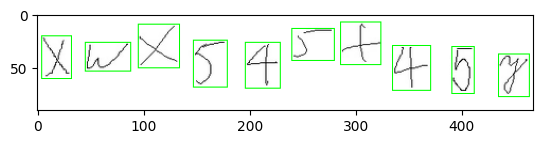

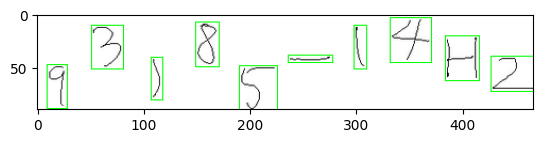

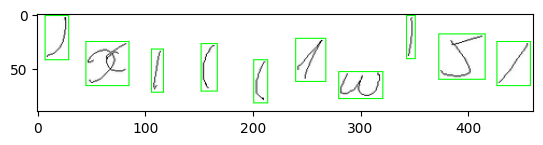

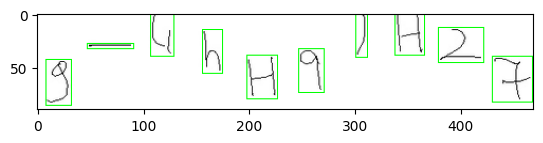

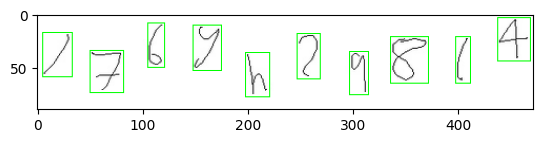

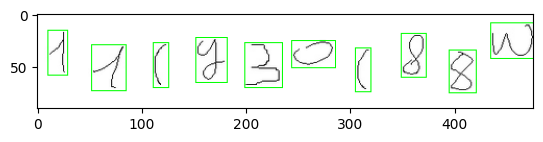

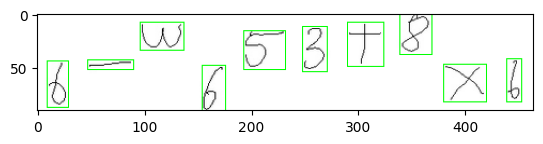

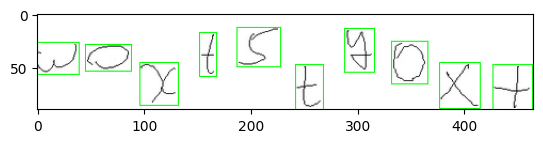

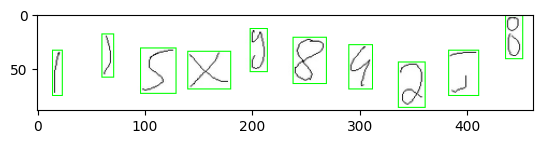

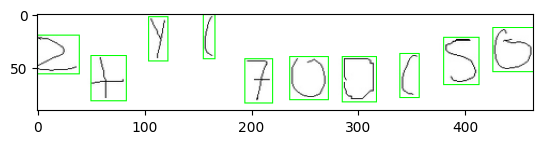

In [168]:
results = []
symb_vectors = []

for string, img_path in my_images_paths.items():
    symb_images = extract_symbols(img_path)
    if len(symb_images) == COUNT_NUMBERS_IN_STRINGS:
        predictions = knn_model.predict(symb_images)
        accuracy = accuracy_score(list(string), predictions)
        results.append((list(string), predictions, accuracy))
    else:
        print('На изображении неправильно определены контуры символов')

In [216]:
from pandas import DataFrame, concat

df_results = DataFrame(results, columns=['Символы исходной строки', 'Предсказанные символы', 'Accuracy'])
mean_accuracy = df_results['Accuracy'].mean()

new_row = DataFrame({
    'Символы исходной строки': [''],
    'Предсказанные символы': ['Средняя accuracy'],
    'Accuracy': [mean_accuracy]
})

df_result = concat([df_results, new_row], ignore_index=True)
df_result

,Символы исходной строки,Предсказанные символы,Accuracy
0,"[X, w, *, 5, 4, 5, +, 4, 5, y]","[X, t, X, 5, +, ), +, 1, ), +]",0.30
1,"[9, 3, ), 8, 5, -, 1, 4, h, 2]","[9, 3, ,, 8, 5, -, 1, +, -, 2]",0.70
2,"[,, X, ,, (, (, 1, w, ,, 5, ,]","[1, +, 1, (, 1, 1, w, 1, 5, -]",0.40
3,"[9, -, 4, h, h, 9, ,, h, 2, 7]","[X, 1, 4, h, h, 9, ,, 1, -, 7]",0.60
4,"[,, 7, 6, y, h, 2, 9, 8, (, 4]","[,, -, 1, y, h, 2, 1, 8, (, 1]",0.60
5,"[1, 1, (, y, 3, 0, (, 8, 8, w]","[1, 1, (, y, 3, ), (, ), 2, 0]",0.60
6,"[6, -, w, 6, 5, 3, +, 8, *, 6]","[6, -, 1, 6, -, 0, +, +, y, t]",0.40
7,"[w, 0, X, t, 5, t, y, 0, *, +]","[w, ,, 1, t, -, t, y, 0, *, +]",0.70
8,"[1, ), 5, X, y, 8, 4, 2, 5, 8]","[5, ), -, X, y, 8, (, 2, 5, )]",0.60
9,"[2, t, y, (, 7, 0, 0, (, 5, 0]","[), +, y, 1, t, 0, 0, (, 5, -]",0.50


### 3.2. Случайно удаляем некоторые символы,и случайно добавляем символы в результат распознавания

In [215]:
import editdistance

def modify_and_calculate_cer(row):
    original = list(row['Символы исходной строки'])
    predicted = list(row['Предсказанные символы'])

    num_to_modify = random.randint(1, 3)
    indices = random.sample(range(len(predicted)), num_to_modify)
    predicted = [predicted[i] for i in range(len(predicted)) if i not in indices]
    predicted += random.choices(symbols, k=num_to_modify)
    
    cer = editdistance.eval(''.join(original), ''.join(predicted)) / max(len(original), len(predicted) or 1)
    return ''.join(original), ''.join(predicted), cer

In [224]:
df_results[['Символы исходной строки', 'Предсказанные символы', 'CER']] = df_results.apply(modify_and_calculate_cer, axis=1, result_type='expand')

mean_cer = df_results['CER'].mean()

new_row = DataFrame({
    'Символы исходной строки': [''],
    'Предсказанные символы': ['Среднее значение'],
    'CER': [mean_cer]
})

df_сer = concat([df_results, new_row], ignore_index=True).drop(columns=['Accuracy'])
df_сer

,Символы исходной строки,Предсказанные символы,CER
0,Xw*545+45y,t5y4X6-403,0.90
1,93)85-14h2,9+)h)12)+h,0.80
2,",X,((1w,5,",+t(04X2h+-,1.00
3,"9-4hh9,h27","4,13wh2)0,",0.90
4,",76yh298(4","(9w-h9+,t0",0.90
5,11(y30(88w,"(305t,310-",1.00
6,6-w653+8*6,6w571(51y3,0.90
7,w0Xt5ty0*+,wt*48w0)X8,0.90
8,1)5Xy84258,2wyyX729X5,0.90
9,2ty(700(50,)+(-628X)w,1.00
